# KUIS 2
## Kelompok 6
### Aldin Ariel Pramudya (2141720233)
### Aryo Deva Saputra (2141720176)
### Muhammad Ega Rama Fernanda (2141720143)
Kelas : 3D

Prodi : D-IV Teknik Inormatika

Jurusan : Teknologi Inormasi

Politeknik Negeri Malang

## Import Library

In [ ]:
import re
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os

In [ ]:
!sudo apt install tesseract-ocr
!pip install pytesseract
!pip install opencv-python


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 10 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 0s (12.2 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debco

In [ ]:
import pytesseract
from pytesseract import Output

## Aldin

### KTP_1

In [2]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Semester 5 Waduh/PCVK/Kuis 2 Pratikum/dataset/ktp_1_double.jpg')
img_original = np.copy(img)

# Apply Gaussian Blur
blurred_img = cv2.GaussianBlur(img_original, (5, 5), 0.5)

# Apply Erosion
kernel_erosion = np.ones((3, 3), np.uint8)
eroded_img = cv2.erode(blurred_img, kernel_erosion, iterations=1)

# Apply Dilation
kernel_dilation = np.ones((5, 5), np.uint8)
dilated_img = cv2.dilate(eroded_img, kernel_dilation, iterations=10)

# Apply Opening (Erosion followed by Dilation)
kernel_opening = np.ones((5, 5), np.uint8)
opening_img = cv2.morphologyEx(dilated_img, cv2.MORPH_OPEN, kernel_opening)

gray = cv2.cvtColor(opening_img, cv2.COLOR_BGR2GRAY)

# Otsu Thresholding
_, otsu_thresholded = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)


In [ ]:
# Lokalisasi (Canny)
edged = cv2.Canny(otsu_thresholded, 50, 150)

In [ ]:
# Segmentasi

def biggest_contour(contours):
    biggest = np.array([])
    max_area = 0
    for i in contours:
        area = cv2.contourArea(i)
        if area > 1000:
            peri = cv2.arcLength(i, True)
            approx = cv2.approxPolyDP(i, 0.015 * peri, True)
            if area > max_area and len(approx) == 4:
                biggest = approx
                max_area = area
    return biggest

contours, hierarchy = cv2.findContours(edged.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
biggest = biggest_contour(contours)
cv2.drawContours(img, [biggest], -1, (0, 255, 0), 3)

# Warp Prespective
points = biggest.reshape(4, 2)
input_points = np.zeros((4, 2), dtype="float32")

points_sum = points.sum(axis=1)
input_points[0] = points[np.argmin(points_sum)]
input_points[3] = points[np.argmax(points_sum)]

points_diff = np.diff(points, axis=1)
input_points[1] = points[np.argmin(points_diff)]
input_points[2] = points[np.argmax(points_diff)]

(top_left, top_right, bottom_right, bottom_left) = input_points
bottom_width = np.sqrt(((bottom_right[0] - bottom_left[0]) ** 2) + ((bottom_right[1] - bottom_left[1]) ** 2))
top_width = np.sqrt(((top_right[0] - top_left[0]) ** 2) + ((top_right[1] - top_left[1]) ** 2))
right_height = np.sqrt(((top_right[0] - bottom_right[0]) ** 2) + ((top_right[1] - bottom_right[1]) ** 2))
left_height = np.sqrt(((top_left[0] - bottom_left[0]) ** 2) + ((top_left[1] - bottom_left[1]) ** 2))

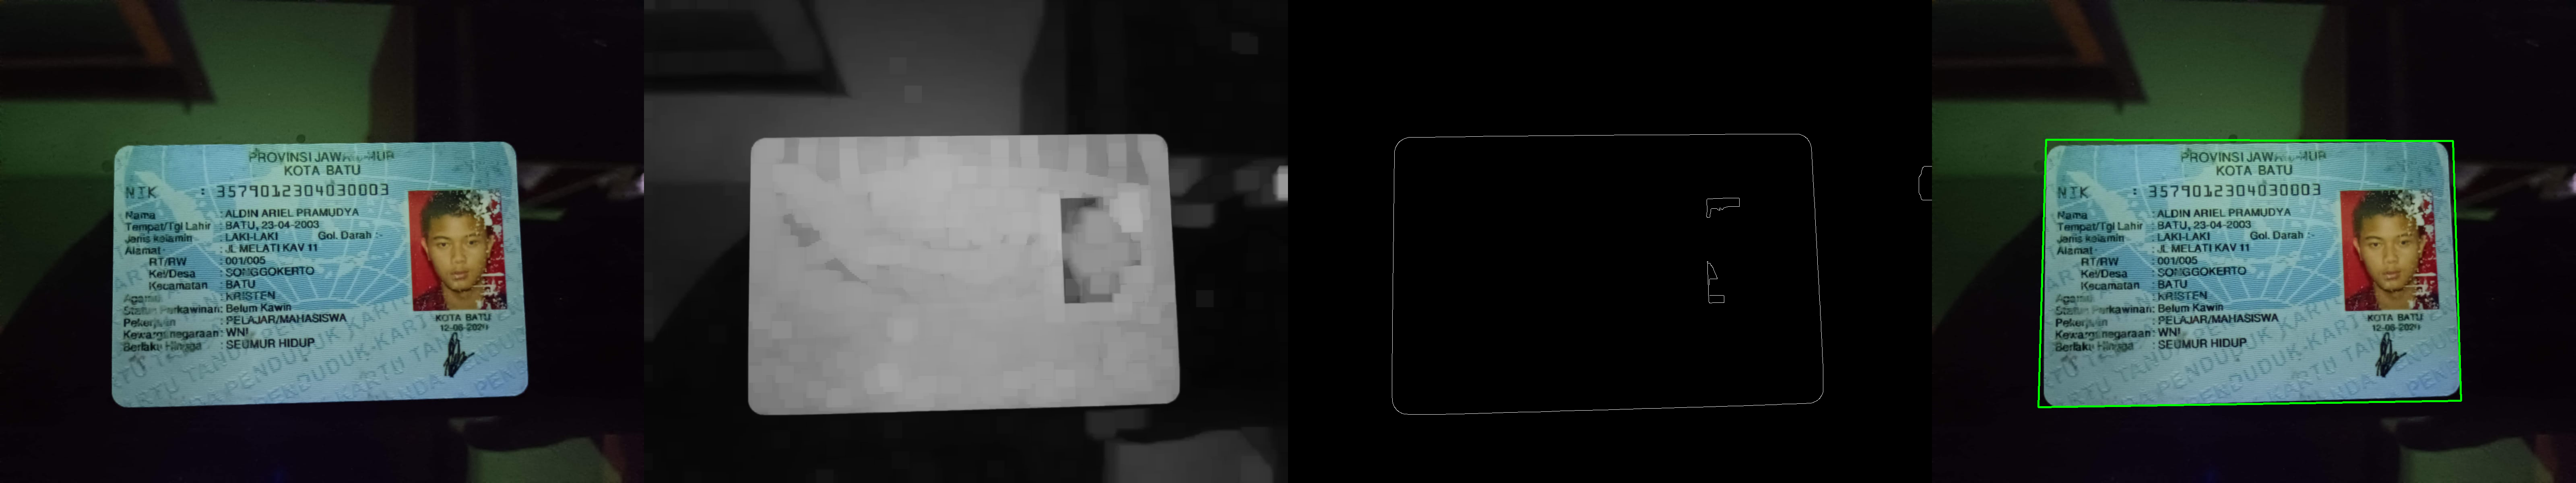

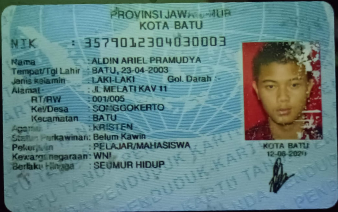

In [ ]:
# Output gambar setelah Warp Prespective
ktp_width = 8.6  # Lebar KTP dalam cm
ktp_height = 5.4  # Tinggi KTP dalam cm

max_width = int(ktp_width * 100 / 2.54)
max_height = int(ktp_height * 100 / 2.54)

# Desired points values in the output image
converted_points = np.float32([[0, 0], [max_width, 0], [0, max_height], [max_width, max_height]])

# Perspective transformation
matrix = cv2.getPerspectiveTransform(input_points, converted_points)
img_output = cv2.warpPerspective(img_original, matrix, (max_width, max_height))

# Image shape modification for hstack
gray = np.stack((gray,) * 3, axis=-1)
edged = np.stack((edged,) * 3, axis=-1)

img_hor = np.hstack((img_original, gray, edged, img))
cv2_imshow(img_hor)
cv2_imshow(img_output)

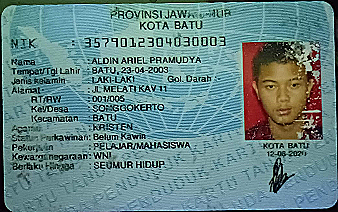

In [ ]:
# Sharpening

kernel_sharpen = np.array([[0,-1,0],
                          [-1,5,-1],
                          [0,-1,0]])

def convolution2d(image, kernel):
    return cv2.filter2D(image, -1, kernel)

result = np.copy(img_output)
ktp_filtered = convolution2d(result, kernel_sharpen)
cv2_imshow(ktp_filtered)

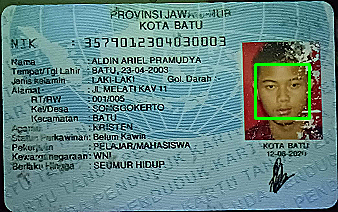

In [ ]:
# Tahap Deteksi
face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/Semester 5 Waduh/PCVK/Jobsheet 12/Face Detection/haarcascade_frontalface_alt.xml')
detect = np.copy(ktp_filtered)
gray = cv2.cvtColor(detect, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5, minSize=(20, 20))

for (x, y, w, h) in faces:
    cv2.rectangle(detect, (x, y), (x+w, y+h), (0, 255, 0), 2)

cv2_imshow(detect)

### KTP_2

Text(0.5, 1.0, 'Original Image')

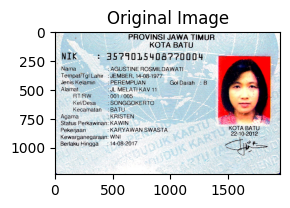

In [ ]:
img = cv2.imread('/content/drive/MyDrive/Semester 5 Waduh/PCVK/Kuis 2 Pratikum/dataset/ktp_2.jpg')
img_original = np.copy(img)

plt.subplot(121), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

Text(0.5, 1.0, 'KTP Face Detection')

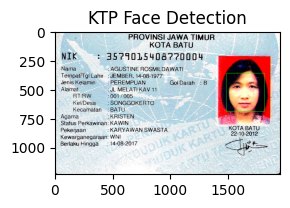

In [ ]:
# Tahap Deteksi
face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/Semester 5 Waduh/PCVK/Jobsheet 12/Face Detection/haarcascade_frontalface_alt.xml')
detect = np.copy(img_original)
gray = cv2.cvtColor(detect, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(gray, scaleFactor=1.2, minNeighbors=5, minSize=(20, 20))

for (x, y, w, h) in faces:
    cv2.rectangle(detect, (x, y), (x+w, y+h), (0, 255, 0), 2)

plt.subplot(121), plt.imshow(cv2.cvtColor(detect, cv2.COLOR_BGR2RGB))
plt.title('KTP Face Detection')

### KTP_9

In [83]:
img = cv2.imread('/content/drive/MyDrive/Semester 5 Waduh/PCVK/Kuis 2 Pratikum/dataset/ktp_9.jpg')
img_original = np.copy(img)

Text(0.5, 1.0, 'Original Image')

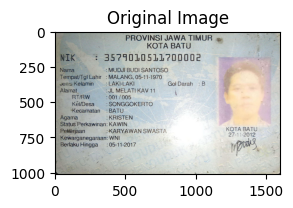

In [85]:
kernel_sharpen = np.array([[0,-1,0],
                          [-1,5,-1],
                          [0,-1,0]])

def convolution2d(image, kernel):
    return cv2.filter2D(image, -1, kernel)

ktp_filtered = convolution2d(img_original, kernel_sharpen)
plt.subplot(121), plt.imshow(cv2.cvtColor(ktp_filtered, cv2.COLOR_BGR2RGB))
plt.title('Sharpened KTP')

Text(0.5, 1.0, 'KTP Face Detection')

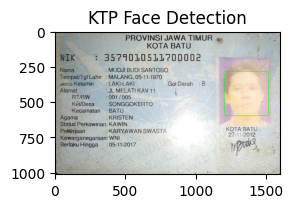

In [86]:
face_cascade = cv2.CascadeClassifier('/content/drive/MyDrive/Semester 5 Waduh/PCVK/Jobsheet 12/Face Detection/haarcascade_frontalface_alt.xml')
detect = np.copy(ktp_filtered)
gray = cv2.cvtColor(detect, cv2.COLOR_BGR2GRAY)

faces = face_cascade.detectMultiScale(gray, scaleFactor=1.2, minNeighbors=5, minSize=(20, 20))

for (x, y, w, h) in faces:
    cv2.rectangle(detect, (x, y), (x+w, y+h), (0, 255, 0), 2)

plt.subplot(121), plt.imshow(cv2.cvtColor(detect, cv2.COLOR_BGR2RGB))
plt.title('KTP Face Detection')

## Ega

### KTP_3

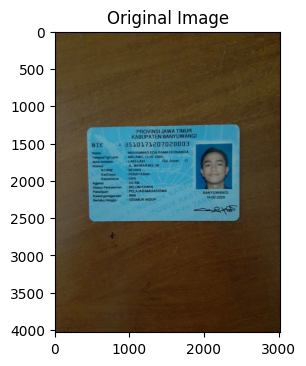

In [3]:
image = cv2.imread('/content/drive/MyDrive/Semester 5 Waduh/PCVK/Kuis 2 Pratikum/dataset/20231126_235242.jpg')


plt.subplot(121), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.show()

In [4]:
# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)

#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 10)

#erosion
def erode(image):
    kernel = np.ones((3,3),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)

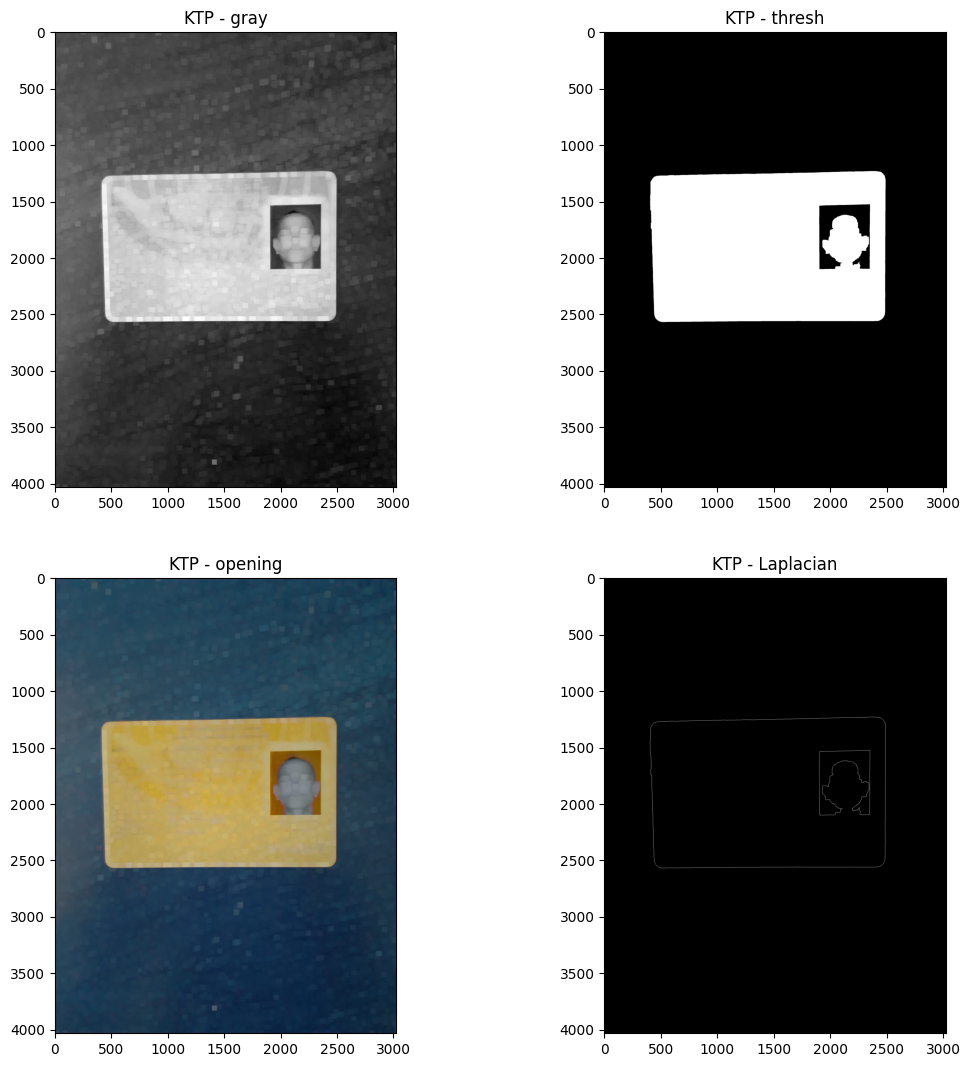

In [5]:
# Preprocess image_rgb
blurred_img = cv2.GaussianBlur(image, (5, 5), 2)
erode = erode(blurred_img)
dilate = dilate(erode)
opening = opening(dilate)
gray = get_grayscale(opening)
thresh = thresholding(gray)
# Laplacian Edge Detection
laplacian = cv2.Laplacian(thresh, cv2.CV_64F)
laplacian_edges = np.uint8(np.absolute(laplacian))
images = {'gray': gray,
          'thresh': thresh,
          'opening': opening,
          'Laplacian': laplacian_edges}

# Plot images after preprocessing
fig = plt.figure(figsize=(13,13))
ax = []

rows = 2
columns = 2
keys = list(images.keys())
for i in range(rows * columns):
    ax.append(fig.add_subplot(rows, columns, i+1))
    ax[-1].set_title('KTP - ' + keys[i])
    plt.imshow(images[keys[i]], cmap='gray')

plt.show()

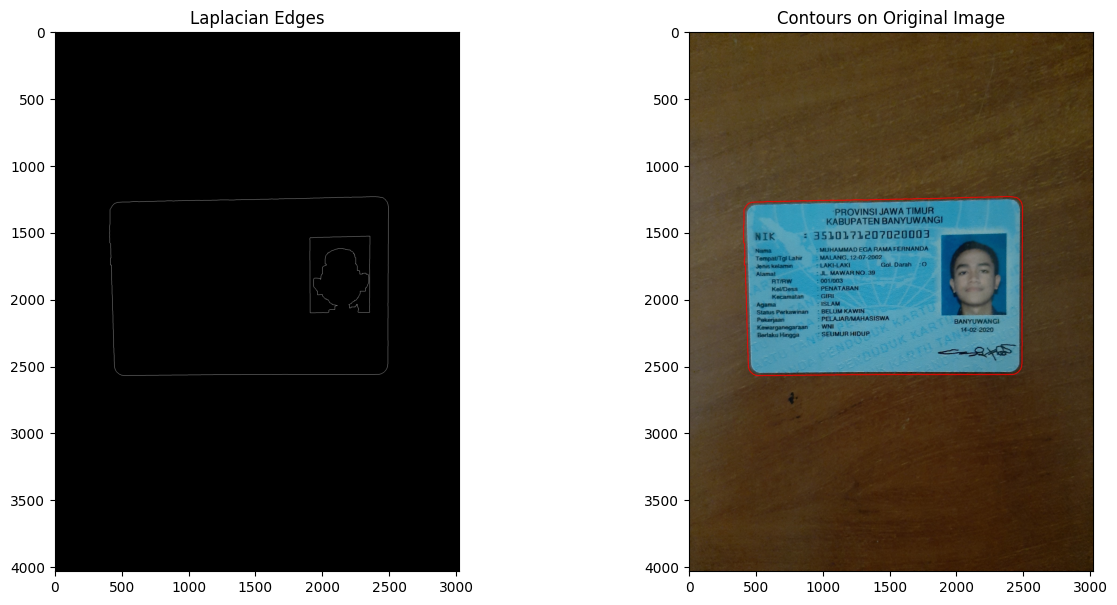

In [6]:
# Ekstraksi kontur
contours, _ = cv2.findContours(laplacian_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Gambar kontur pada gambar asli
contour_image = image.copy()
cv2.drawContours(contour_image, contours, -1, (0, 0, 255), 5)

# Plot gambar setelah ekstraksi kontur
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

axes[0].imshow(laplacian_edges, cmap='gray')
axes[0].set_title('Laplacian Edges')

axes[1].imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
axes[1].set_title('Contours on Original Image')

plt.show()

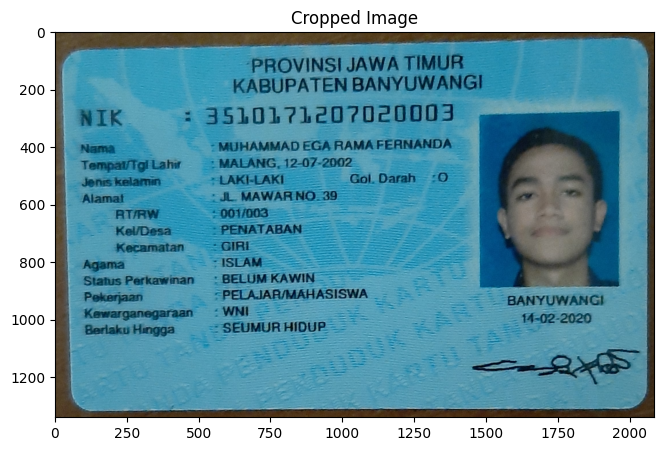

In [7]:
# Crop pada setiap kontur
cropped_images = []
for i, contour in enumerate(contours):
    x, y, w, h = cv2.boundingRect(contour)
    cropped = image[y:y+h, x:x+w]
    cropped_images.append(cropped)

# Plot gambar hasil cropping
fig, axes = plt.subplots(1, len(cropped_images), figsize=(10, 5))

# Memastikan bahwa axes adalah daftar (list) yang dapat diindeks
if not isinstance(axes, np.ndarray):
    axes = np.array([axes])

for i, cropped in enumerate(cropped_images):
    axes[i].imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
    axes[i].set_title(f'Cropped Image')

plt.show()

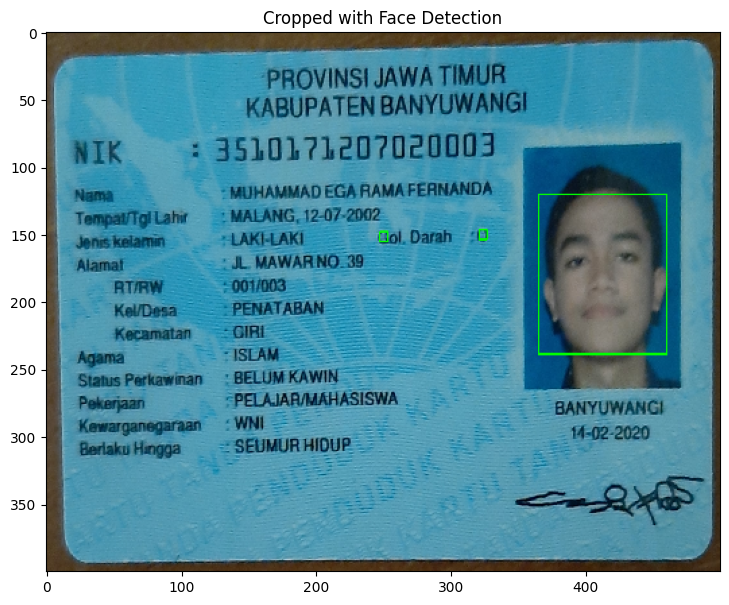

In [9]:
# Load the face cascade
cascade_wajah = cv2.CascadeClassifier('/content/drive/MyDrive/Semester 5 Waduh/PCVK/Jobsheet 12/Face Detection/haarcascade_frontalface_alt.xml')

# Plot gambar hasil cropping dengan deteksi wajah
fig, axes = plt.subplots(1, len(cropped_images), figsize=(15, 7))

# Memastikan bahwa axes adalah daftar (list) yang dapat diindeks
if not isinstance(axes, np.ndarray):
    axes = np.array([axes])

for i, cropped in enumerate(cropped_images):
    # Deteksi wajah
    roi_wajah = cascade_wajah.detectMultiScale(cropped)
    for (x,y,w,h) in roi_wajah:
        cv2.rectangle(cropped,(x,y),(x+w,y+h),(0,255,0),3)

    # Mengatur ukuran gambar
    resized_cropped = cv2.resize(cropped, (500, 400))  # Ganti ukuran sesuai kebutuhan

    axes[i].imshow(cv2.cvtColor(resized_cropped, cv2.COLOR_BGR2RGB))
    axes[i].set_title(f'Cropped with Face Detection')

plt.show()

### KTP_7

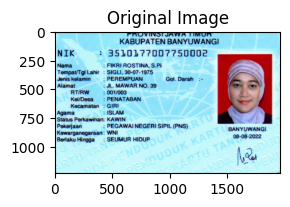

In [10]:
image = cv2.imread('/content/drive/MyDrive/Semester 5 Waduh/PCVK/Kuis 2 Pratikum/dataset/ktp_7.jpg')


plt.subplot(121), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.show()

In [11]:
# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)

#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 10)

#erosion
def erode(image):
    kernel = np.ones((3,3),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)

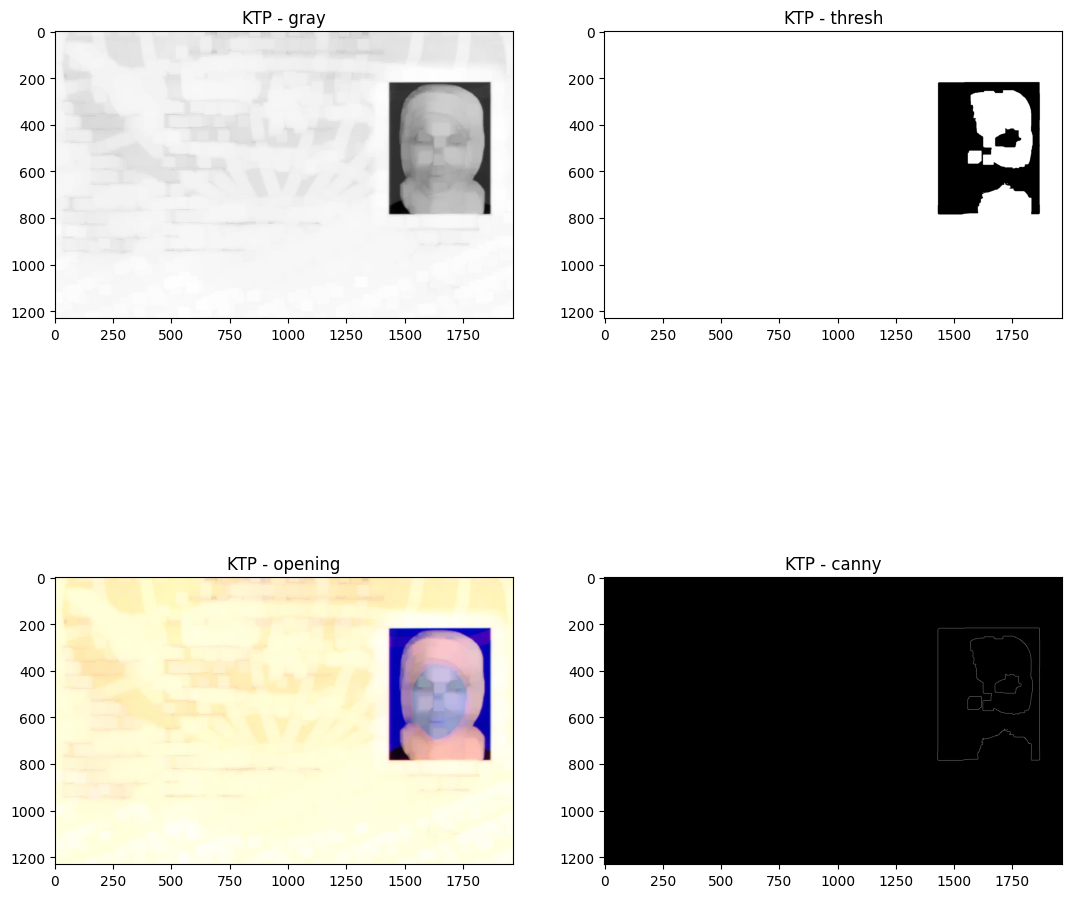

In [12]:
# Preprocess image_rgb
blurred_img = cv2.GaussianBlur(image, (5, 5), 2)
erode = erode(blurred_img)
dilate = dilate(erode)
opening = opening(dilate)
gray = get_grayscale(opening)
thresh = thresholding(gray)
# Canny Edge Detection
canny = cv2.Canny(thresh, 50, 150)
images = {'gray': gray,
          'thresh': thresh,
          'opening': opening,
          'canny': canny}

# Plot images after preprocessing
fig = plt.figure(figsize=(13,13))
ax = []

rows = 2
columns = 2
keys = list(images.keys())
for i in range(rows * columns):
    ax.append(fig.add_subplot(rows, columns, i+1))
    ax[-1].set_title('KTP - ' + keys[i])
    plt.imshow(images[keys[i]], cmap='gray')

plt.show()

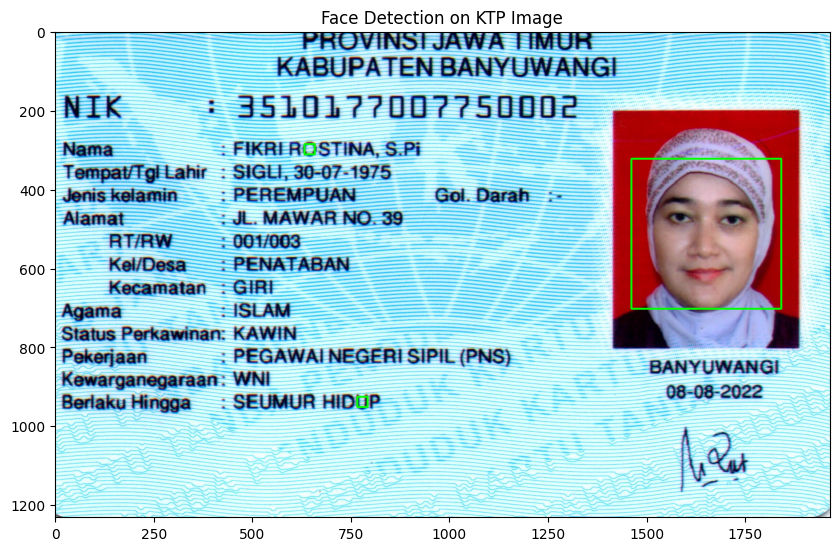

In [14]:
# Load the face cascade
cascade_wajah = cv2.CascadeClassifier('/content/drive/MyDrive/Semester 5 Waduh/PCVK/Jobsheet 12/Face Detection/haarcascade_frontalface_alt.xml')

# Deteksi wajah
roi_wajah = cascade_wajah.detectMultiScale(image)
for (x, y, w, h) in roi_wajah:
    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 3)

# Tampilkan gambar dengan deteksi wajah
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Face Detection on KTP Image')
plt.show()

### KTP_8

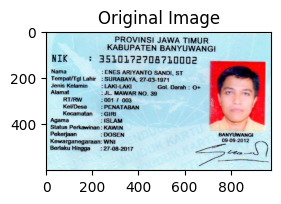

In [15]:
image = cv2.imread('/content/drive/MyDrive/Semester 5 Waduh/PCVK/Kuis 2 Pratikum/dataset/ktp_8.jpg')

plt.subplot(121), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')

plt.show()

In [16]:
# get grayscale image
def get_grayscale(image):
    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# noise removal
def remove_noise(image):
    return cv2.medianBlur(image,5)

#thresholding
def thresholding(image):
    return cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]

#dilation
def dilate(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.dilate(image, kernel, iterations = 10)

#erosion
def erode(image):
    kernel = np.ones((3,3),np.uint8)
    return cv2.erode(image, kernel, iterations = 1)

#opening - erosion followed by dilation
def opening(image):
    kernel = np.ones((5,5),np.uint8)
    return cv2.morphologyEx(image, cv2.MORPH_OPEN, kernel)

#canny edge detection
def canny(image):
    return cv2.Canny(image, 100, 200)

#skew correction
def deskew(image):
    coords = np.column_stack(np.where(image > 0))
    angle = cv2.minAreaRect(coords)[-1]
    if angle < -45:
        angle = -(90 + angle)
    else:
        angle = -angle
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    M = cv2.getRotationMatrix2D(center, angle, 1.0)
    rotated = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)
    return rotated

#template matching
def match_template(image, template):
    return cv2.matchTemplate(image, template, cv2.TM_CCOEFF_NORMED)

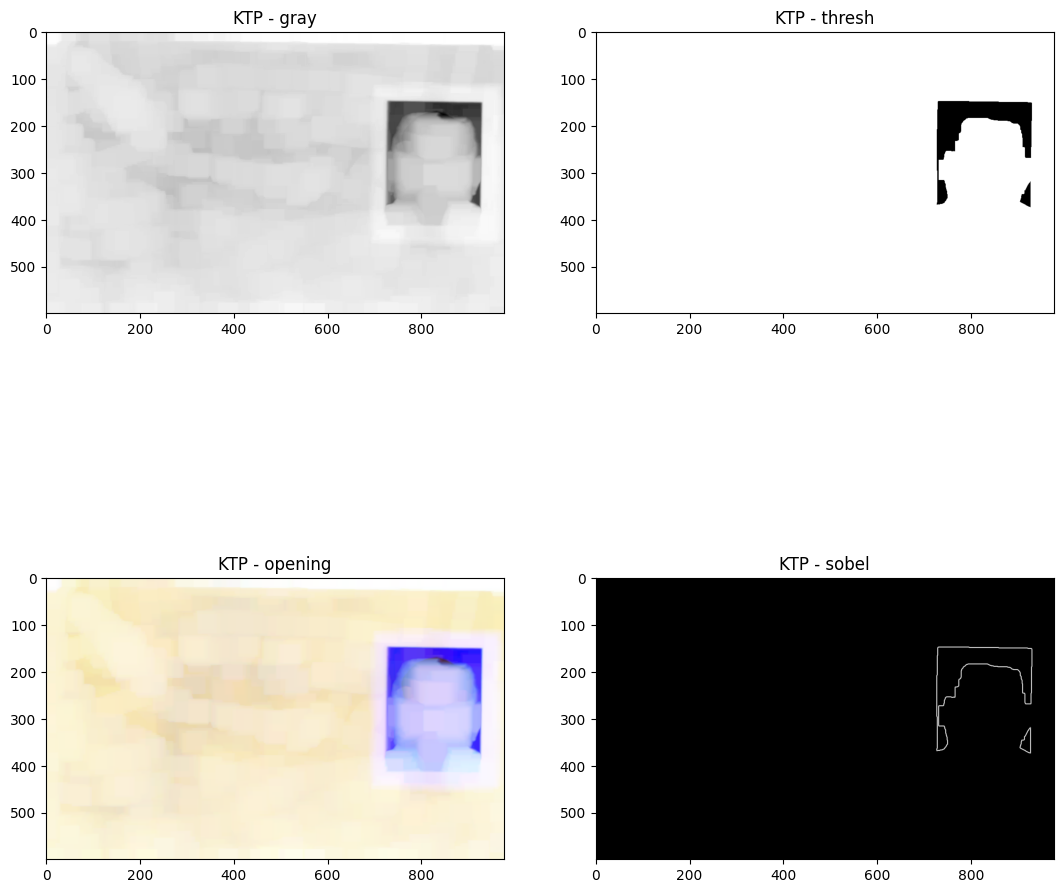

In [17]:
# Preprocess image_rgb
blurred_img = cv2.GaussianBlur(image, (5, 5), 2)
erode = erode(blurred_img)
dilate = dilate(erode)
opening = opening(dilate)
gray = get_grayscale(opening)
thresh = thresholding(gray)
# Sobel Edge Detection
sobel_x = cv2.Sobel(thresh, cv2.CV_64F, 1, 0, ksize=3)
sobel_y = cv2.Sobel(thresh, cv2.CV_64F, 0, 1, ksize=3)
sobel_combined = cv2.magnitude(sobel_x, sobel_y)
images = {'gray': gray,
          'thresh': thresh,
          'opening': opening,
          'sobel': sobel_combined}

# Plot images after preprocessing
fig = plt.figure(figsize=(13,13))
ax = []

rows = 2
columns = 2
keys = list(images.keys())
for i in range(rows * columns):
    ax.append(fig.add_subplot(rows, columns, i+1))
    ax[-1].set_title('KTP - ' + keys[i])
    plt.imshow(images[keys[i]], cmap='gray')

plt.show()

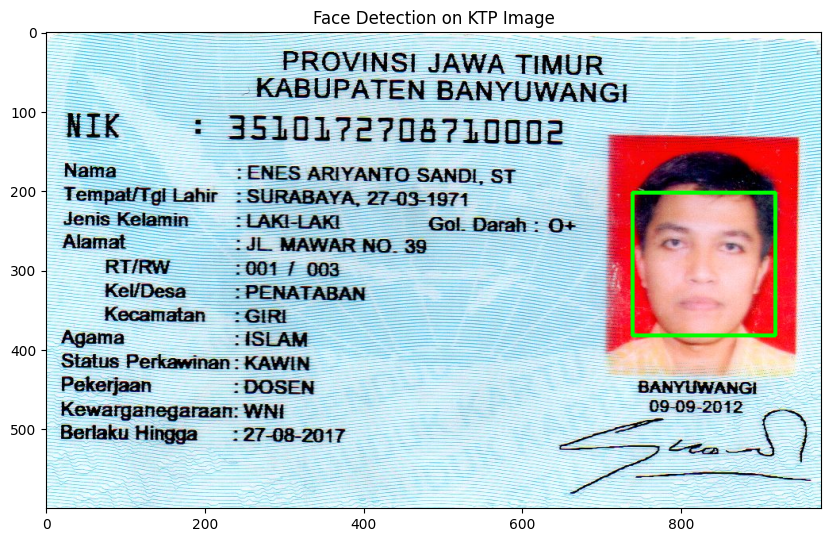

In [18]:
# Load the face cascade
cascade_wajah = cv2.CascadeClassifier('/content/drive/MyDrive/Semester 5 Waduh/PCVK/Jobsheet 12/Face Detection/haarcascade_frontalface_alt.xml')

# Deteksi wajah
roi_wajah = cascade_wajah.detectMultiScale(image)
for (x, y, w, h) in roi_wajah:
    cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 3)

# Tampilkan gambar dengan deteksi wajah
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Face Detection on KTP Image')
plt.show()

## Aryo

### KTP 4

In [87]:
# Load the image
img = cv2.imread('/content/drive/MyDrive/Semester 5 Waduh/PCVK/Kuis 2 Pratikum/dataset/ktp_4.jpg')

# Convert the image to grayscale
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Apply Otsu's thresholding with adjusted parameters
_, otsu_thresholded = cv2.threshold(img_gray, 90, 255, cv2.THRESH_BINARY)

In [88]:
# Find contours
contours, hierarchy = cv2.findContours(otsu_thresholded, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

# Draw contours on the original image
contour_img = img.copy()
cv2.drawContours(contour_img, contours, -1, (0, 0, 255), 3)

array([[[44, 25, 20],
        [43, 27, 21],
        [43, 26, 23],
        ...,
        [50, 39, 42],
        [52, 38, 42],
        [52, 38, 42]],

       [[44, 25, 20],
        [43, 27, 21],
        [41, 26, 23],
        ...,
        [50, 39, 42],
        [51, 37, 41],
        [51, 37, 41]],

       [[42, 25, 22],
        [43, 26, 23],
        [41, 26, 23],
        ...,
        [50, 39, 42],
        [50, 39, 42],
        [49, 38, 41]],

       ...,

       [[ 7,  9, 10],
        [ 7,  9, 10],
        [ 7,  9, 10],
        ...,
        [34, 33, 29],
        [39, 38, 34],
        [46, 45, 41]],

       [[ 7,  8, 12],
        [ 7,  8, 12],
        [ 7,  8, 12],
        ...,
        [35, 34, 30],
        [43, 42, 38],
        [51, 50, 46]],

       [[ 6,  7, 11],
        [ 7,  8, 12],
        [ 7,  8, 12],
        ...,
        [35, 34, 30],
        [44, 43, 39],
        [54, 53, 49]]], dtype=uint8)

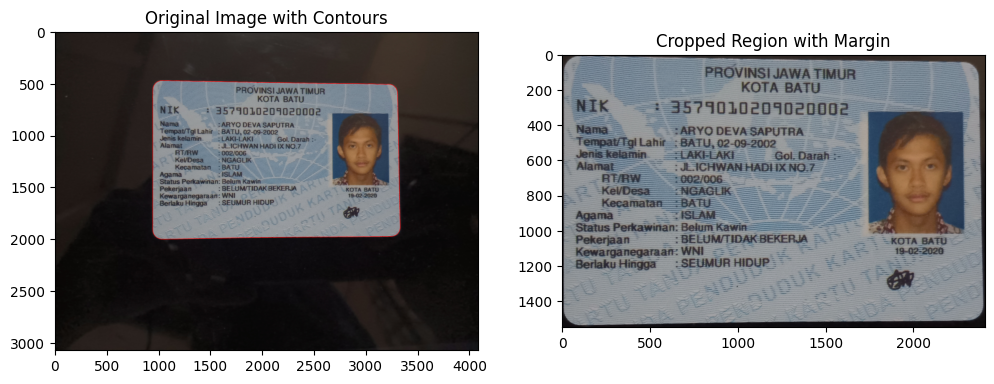

In [89]:
# Display the original image with contours
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(contour_img, cv2.COLOR_BGR2RGB))
plt.title('Original Image with Contours')

# Crop and display each contour with a margin
margin = 10  # Adjust the margin as needed

for contour in contours:
    # Get bounding box coordinates
    x, y, w, h = cv2.boundingRect(contour)

    # Add a margin to the bounding box
    x -= margin
    y -= margin
    w += 2 * margin
    h += 2 * margin

    # Ensure coordinates are within the image boundaries
    x = max(0, x)
    y = max(0, y)
    w = min(w, img.shape[1] - x)
    h = min(h, img.shape[0] - y)

    # Crop the region of interest
    cropped_region = img[y:y+h, x:x+w]

    # Display the cropped region
    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(cropped_region, cv2.COLOR_BGR2RGB))
    plt.title('Cropped Region with Margin')
    plt.show()


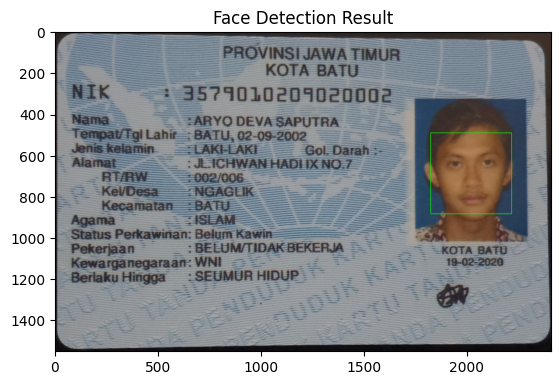

In [91]:
import cv2
import matplotlib.pyplot as plt

# Load cascade classifier
cascade_wajah = cv2.CascadeClassifier('/content/drive/MyDrive/Semester 5 Waduh/PCVK/Jobsheet 12/Face Detection/haarcascade_frontalface_alt.xml')

# Panggil fungsi face_detection jika ada objek KTP terdeteksi
if np.any(cropped_region):
    # Convert cropped_region to grayscale
    cropped_gray = cv2.cvtColor(cropped_region, cv2.COLOR_BGR2GRAY)

    # Face detection
    faces = cascade_wajah.detectMultiScale(cropped_gray, scaleFactor=1.3, minNeighbors=5, minSize=(20, 20))

    # Draw rectangles around the detected faces
    for (x, y, w, h) in faces:
        cv2.rectangle(cropped_region, (x, y), (x+w, y+h), (0, 255, 0), 2)

    # Display the result
    plt.imshow(cv2.cvtColor(cropped_region, cv2.COLOR_BGR2RGB))
    plt.title('Face Detection Result')
    plt.show()


### KTP 5 & KTP 6


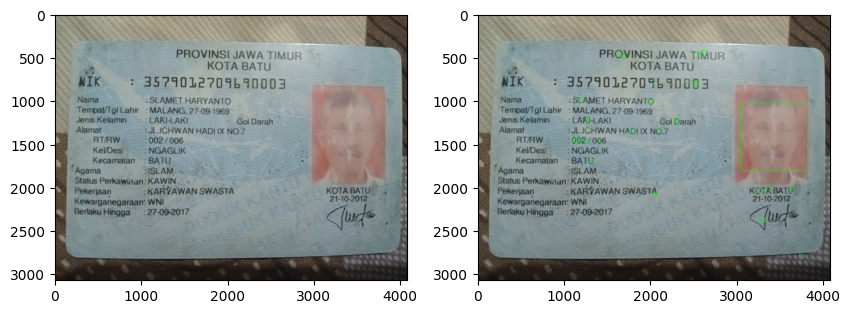

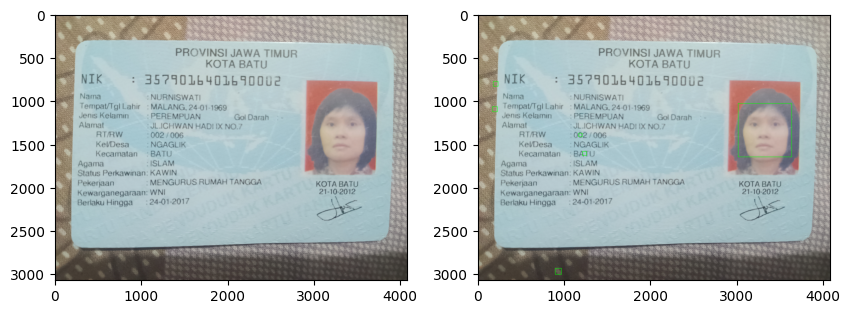

In [92]:
import cv2 as cv

def face_detection(image_path):
    img = cv.imread(image_path)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    faces = cascade_wajah.detectMultiScale(gray)

    for (x, y, w, h) in faces:
        cv.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 3)

    plt.figure(figsize=(10, 10))
    plt.subplot(121), plt.imshow(cv.cvtColor(cv.imread(image_path), cv.COLOR_BGR2RGB))
    plt.subplot(122), plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
    plt.show()


image_paths = [
    '/content/drive/MyDrive/Semester 5 Waduh/PCVK/Kuis 2 Pratikum/dataset/ktp_5.jpg',
    '/content/drive/MyDrive/Semester 5 Waduh/PCVK/Kuis 2 Pratikum/dataset/ktp_6.jpg',
]

cascade_wajah = cv.CascadeClassifier('/content/drive/MyDrive/Semester 5 Waduh/PCVK/Jobsheet 12/Face Detection/haarcascade_frontalface_alt.xml')

for image_path in image_paths:
    face_detection(image_path)